In [2]:
import sys, os
sys.path.append('..')
import bioGRID as bg
import STRING
import IntAct
import HuRI
import random as rn
import onPPILinkPred as ppiLPred
import numpy as np
import json
from itertools import combinations
from matplotlib import pyplot as plt
from statistics import mean
from statistics import median
import traversalHelper as tr
import pandas as pd
from collections import defaultdict
import matplotlib.gridspec as gridspec
import math
from matplotlib.ticker import NullFormatter
from scipy.signal import savgol_filter
import MINT
import helper as hr
from scipy.interpolate import interp1d
import seaborn as sns

# Data Generating

data to generate: sampled PPI dataset (bioGRID & STRING & InAct (spoke mode), MINT), 50% sampled, 10 samples

In [3]:
# DataFrame standard: {nodeA, nodeB, type, score}
bioGRID_GGI, bioGRID_PPI = bioGRID.parse_bioGRID(root="../")

sampleFName, sampleBase = ['bioGRID'], [bioGRID_PPI]
for i in range(len(sampleFName)):
    ppi = [list(arr) for arr in np.asarray(sampleBase[i][['nodeA', 'nodeB']])]
    sampledPPIs = [rn.sample(ppi, int(len(ppi)*0.5)) for i in range(10)]
    with open("./genData/{}_sampledPPIs.json".format(sampleFName[i]), "w") as f:
        f.write(json.dumps(sampledPPIs))

C:\Users\andy8\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (1,2,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\andy8\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (1,2,18) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [36]:
# DataFrame standard: {nodeA, nodeB, type, score}
MINT_GGI, MINT_PPI = MINT.parse_MINT(root="../")

sampleFName, sampleBase = ['MINT'], [MINT_PPI]
for i in range(len(sampleFName)):
    ppi = [list(arr) for arr in np.asarray(sampleBase[i][['nodeA', 'nodeB']])]
    sampledPPIs = [rn.sample(ppi, int(len(ppi)*0.5)) for i in range(10)]
    with open("./genData/{}_sampledPPIs.json".format(sampleFName[i]), "w") as f:
        f.write(json.dumps(sampledPPIs))

In [15]:
# DataFrame standard: {nodeA, nodeB, type, score}
STRING_GGI, STRING_PPI = STRING.parse_STRING(root="../")

sampleFName, sampleBase = ['STRING'], [STRING_PPI]
for i in range(len(sampleFName)):
    ppi = [list(arr) for arr in np.asarray(sampleBase[i][['nodeA', 'nodeB']])]
    sampledPPIs = [rn.sample(ppi, int(len(ppi)*0.5)) for i in range(10)]
    with open("./genData/{}_sampledPPIs.json".format(sampleFName[i]), "w") as f:
        f.write(json.dumps(sampledPPIs))

# Data Crunching

see dataGen_Yeast.py, since running in jupyter notebook may have errors

# Read Data

In [8]:
predPPIs = {}
with open('./resultData/trimmed_predPPIs.json', 'r') as f:
    for line in f.readlines(): predPPIs.update(json.loads(line))
print(list(predPPIs.keys()))

['uvSpec_xySpec_xyContrib_tenTrial_bioGRID', 'xyContrib_dualCN_tenTrial_bioGRID', 'commonNeighbor_tenTrial_bioGRID', 'L3Normalizing_tenTrial_bioGRID', 'uvSpec_xySpec_xyContrib_tenTrial_STRING', 'xyContrib_dualCN_tenTrial_STRING', 'commonNeighbor_tenTrial_STRING', 'L3Normalizing_tenTrial_STRING', 'L3_tenTrial_bioGRID', 'L3_tenTrial_STRING', 'L3uvJoin_tenTrial_bioGRID', 'L3uvJoin_tenTrial_STRING', 'xyContrib_dualCN_uvJoin_tenTrial_bioGRID', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_bioGRID', 'xyContrib_dualCN_uvJoin_tenTrial_STRING', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_STRING', 'commonNeighbor_tenTrial_IntAct', 'L3uvJoin_tenTrial_IntAct', 'xyContrib_dualCN_uvJoin_tenTrial_IntAct', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_IntAct', 'commonNeighbor_tenTrial_MINT', 'L3uvJoin_tenTrial_MINT', 'xyContrib_dualCN_uvJoin_tenTrial_MINT', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_MINT', 'commonNeighbor_tenTrial_IntAct_spoke', 'L3uvJoin_tenTrial_IntAct_spoke', 'xyContrib_dualCN_uvJoin_tenTrial_Int

In [9]:
# samplePPI
bg_samplePPIs, STRING_samplePPIs, MINT_samplePPIs, IntAct_samplePPIs, IntAct_spoke_samplePPIs = [], [], [], [], []
with open('./genData/bioGRID_sampledPPIs.json', 'r') as f:
    bg_samplePPIs = json.loads(f.read())
with open('./genData/STRING_sampledPPIs.json', 'r') as f:
    STRING_samplePPIs = json.loads(f.read())
with open('./genData/IntAct_spoke_sampledPPIs.json', 'r') as f:
    IntAct_spoke_samplePPIs = json.loads(f.read())
with open('./genData/MINT_sampledPPIs.json', 'r') as f:
    MINT_samplePPIs = json.loads(f.read())
bg_samplePPIr, STRING_samplePPIr, IntAct_samplePPIr, IntAct_spoke_samplePPIr, MINT_samplePPIr = [], [], [], [], []
for ppis in bg_samplePPIs: bg_samplePPIr.append(tr.Helper.binary_to_relation(tr.Helper.to_dual_binary_relation(ppis), rSet=True))
for ppis in STRING_samplePPIs: STRING_samplePPIr.append(tr.Helper.binary_to_relation(tr.Helper.to_dual_binary_relation(ppis), rSet=True))
for ppis in MINT_samplePPIs: MINT_samplePPIr.append(tr.Helper.binary_to_relation(tr.Helper.to_dual_binary_relation(ppis), rSet=True))
for ppis in IntAct_spoke_samplePPIs: IntAct_spoke_samplePPIr.append(tr.Helper.binary_to_relation(tr.Helper.to_dual_binary_relation(ppis), rSet=True))
print(bg_samplePPIs[0][0:5], len(bg_samplePPIs))
print(STRING_samplePPIs[0][0:5], len(STRING_samplePPIs))

[['SSB2', 'NAT1'], ['TFB1', 'APE1'], ['MMS22', 'MMS1'], ['NOP14', 'RPS11A'], ['VPS29', 'PEP8']] 10
[['NOP58', 'RPS0A'], ['BDF1', 'SNT2'], ['SFH1', 'UAF30'], ['RPS3', 'SLX9'], ['HSC82', 'SCP160']] 10


In [8]:
precRecMap = {}
with open('./resultData/PRCurveMap.json', 'r') as f: precRecMap = json.loads(f.read())
print(list(precRecMap.keys()))

['commonNeighbor_tenTrial_bioGRID_0', 'commonNeighbor_tenTrial_bioGRID_1', 'commonNeighbor_tenTrial_bioGRID_2', 'commonNeighbor_tenTrial_bioGRID_3', 'commonNeighbor_tenTrial_bioGRID_4', 'commonNeighbor_tenTrial_bioGRID_5', 'commonNeighbor_tenTrial_bioGRID_6', 'commonNeighbor_tenTrial_bioGRID_7', 'commonNeighbor_tenTrial_bioGRID_8', 'commonNeighbor_tenTrial_bioGRID_9', 'commonNeighbor_tenTrial_STRING_0', 'commonNeighbor_tenTrial_STRING_1', 'commonNeighbor_tenTrial_STRING_2', 'commonNeighbor_tenTrial_STRING_3', 'commonNeighbor_tenTrial_STRING_4', 'commonNeighbor_tenTrial_STRING_5', 'commonNeighbor_tenTrial_STRING_6', 'commonNeighbor_tenTrial_STRING_7', 'commonNeighbor_tenTrial_STRING_8', 'commonNeighbor_tenTrial_STRING_9', 'commonNeighbor_tenTrial_bioGRID_GGI_0', 'commonNeighbor_tenTrial_bioGRID_GGI_1', 'commonNeighbor_tenTrial_bioGRID_GGI_2', 'commonNeighbor_tenTrial_bioGRID_GGI_3', 'commonNeighbor_tenTrial_bioGRID_GGI_4', 'commonNeighbor_tenTrial_bioGRID_GGI_5', 'commonNeighbor_tenTria

In [13]:
GOScores, GOPPI = {}, {}
with open('./GOSemSimFinalizedData/GOScore.json', 'r') as f: GOScores = json.loads(f.read())
with open('./GOSemSimFinalizedData/GOPPI.json', 'r') as f: GOPPI = json.loads(f.read())
print(list(GOScores.keys()))

['commonNeighbor_tenTrial_bioGRID', 'L3Normalizing_tenTrial_bioGRID', 'xyContrib_dualCN_tenTrial_bioGRID', 'uvSpec_xySpec_xyContrib_tenTrial_bioGRID', 'commonNeighbor_tenTrial_STRING', 'L3Normalizing_tenTrial_STRING', 'xyContrib_dualCN_tenTrial_STRING', 'uvSpec_xySpec_xyContrib_tenTrial_STRING', 'L3uvJoin_tenTrial_bioGRID', 'xyContrib_dualCN_uvJoin_tenTrial_bioGRID', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_bioGRID', 'L3uvJoin_tenTrial_STRING', 'xyContrib_dualCN_uvJoin_tenTrial_STRING', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_STRING', 'commonNeighbor_tenTrial_MINT', 'L3uvJoin_tenTrial_MINT', 'xyContrib_dualCN_uvJoin_tenTrial_MINT', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_MINT', 'commonNeighbor_tenTrial_IntAct', 'L3uvJoin_tenTrial_IntAct', 'xyContrib_dualCN_uvJoin_tenTrial_IntAct', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_IntAct', 'commonNeighbor_tenTrial_IntAct_spoke', 'L3uvJoin_tenTrial_IntAct_spoke', 'xyContrib_dualCN_uvJoin_tenTrial_IntAct_spoke', 'uvSpec_xySpec_xyContrib_uvJoin_t

In [ ]:
# check data
predPPIsK = list(predPPIs.keys())[0]
GOScoresK = list(GOScores.keys())[0]
print(len(predPPIs[predPPIsK][0]), len(GOScores[GOScoresK][0]))

In [11]:
essGenes, essGenesFromPPI = [], []
with open('./../data/parsed/giaever_essentialGenes.json', 'r') as f: essGenes = json.loads(f.read())
print(len(essGenes), essGenes[0:5])
essGenes = set(essGenes)

1080 ['TFC3', 'EFB1', 'MAK16', 'PRP45', 'POP5']


# Data Properties

In [14]:
# dataset edges
bioGRID_GGI_df, bioGRID_PPI_df = bg.parse_bioGRID(root='../')
STRING_GGI_df, STRING_PPI_df = STRING.parse_STRING(root='../')
IntAct_GGI_df, IntAct_PPI_df = IntAct.parse_IntAct(root='../', spokeModel=True)
MINT_GGI_df, MINT_PPI_df = MINT.parse_MINT(root='../')
print('PPI size, STRING: {}, bioGRID: {}, IntAct_spoke: {}, MINT: {}'.format(
    len(STRING_PPI_df.index), len(bioGRID_PPI_df.index), len(IntAct_PPI_df.index), len(MINT_PPI_df.index)))

print('non-PPI size, STRING: {}, bioGRID: {}, IntAct_spoke: {}, MINT: {}'.format(
    len(STRING_GGI_df.index), len(bioGRID_GGI_df.index), len(IntAct_GGI_df.index), len(MINT_GGI_df.index)))

bioGRID_nodes = tr.Helper.binary_relation_to_node(bioGRID_PPI_df[['nodeA', 'nodeB']].values.tolist())
STRING_nodes = tr.Helper.binary_relation_to_node(STRING_PPI_df[['nodeA', 'nodeB']].values.tolist())
IntAct_nodes = tr.Helper.binary_relation_to_node(IntAct_PPI_df[['nodeA', 'nodeB']].values.tolist())
MINT_nodes = tr.Helper.binary_relation_to_node(MINT_PPI_df[['nodeA', 'nodeB']].values.tolist())
print('# of nodes, bioGRID: {}, STRING: {}, IntAct_spoke: {}, MINT: {}'.format(
    len(bioGRID_nodes), len(STRING_nodes), len(IntAct_nodes), len(MINT_nodes)))

# average candidate edges
STRING_candidateSz, bioGRID_candidateSz, IntAct_candidateSz, MINT_candidateSz = [], [], [], []
for i in range(0, 10):
    with open('./resultData/commonNeighbor_tenTrial_STRING_{}_PPI.json'.format(i), 'r') as f:
        STRING_candidateSz.append(len(json.loads(f.read())))
    with open('./resultData/commonNeighbor_tenTrial_bioGRID_{}_PPI.json'.format(i), 'r') as f:
        bioGRID_candidateSz.append(len(json.loads(f.read())))
    with open('./resultData/commonNeighbor_tenTrial_IntAct_spoke_{}_PPI.json'.format(i), 'r') as f:
        IntAct_candidateSz.append(len(json.loads(f.read())))
    with open('./resultData/commonNeighbor_tenTrial_MINT_{}_PPI.json'.format(i), 'r') as f:
        MINT_candidateSz.append(len(json.loads(f.read())))
print("candidate size, STRING: {}, bioGRID: {}, IntAct_spoke: {}, MINT: {}".format(
    mean(STRING_candidateSz), mean(bioGRID_candidateSz), mean(IntAct_candidateSz), mean(MINT_candidateSz)))    

# selected top edges
trimNum = {'bioGRID': int(len([*bg.parse_bioGRID(root='../')][1].index)*0.5)
        , 'STRING': int(len([*STRING.parse_STRING(root='../')][1].index)*0.5)
        , 'IntAct': int(len([*IntAct.parse_IntAct(root='../', spokeModel=True)][1].index)*0.5)
        , 'MINT': int(len([*MINT.parse_MINT(root='../')][1].index)*0.5)}
print("top n edges: bioGRID: {}, STRING: {}, IntAct_spoke: {}, MINT: {}".format(
  trimNum['bioGRID'], trimNum['STRING'], trimNum['IntAct'], trimNum['MINT']))

PPI size, STRING: 46298, bioGRID: 172448, IntAct_spoke: 143750, MINT: 39429
non-PPI size, STRING: 62525, bioGRID: 576462, IntAct_spoke: 73, MINT: 266
# of nodes, bioGRID: 6835, STRING: 4574, IntAct_spoke: 5418, MINT: 4048
candidate size, STRING: 8870602.6, bioGRID: 20115400, IntAct_spoke: 11660761.4, MINT: 6479681
top n edges: bioGRID: 86224, STRING: 23149, IntAct_spoke: 71875, MINT: 19714


In [15]:
# overlap evaluation
_, bioGRID_PPI_df = bg.parse_bioGRID(root='../')
_, STRING_PPI_df = STRING.parse_STRING(root='../')
_, IntAct_PPI_df = IntAct.parse_IntAct(root='../', spokeModel=True)
_, MINT_PPI_df = MINT.parse_MINT(root='../')

bioGRID_PPIs = set(tr.Helper.list_to_pathStrs([sorted(i) for i in bioGRID_PPI_df[['nodeA', 'nodeB']].values.tolist()]))
STRING_PPIs = set(tr.Helper.list_to_pathStrs([sorted(i) for i in STRING_PPI_df[['nodeA', 'nodeB']].values.tolist()]))
IntAct_PPIs = set(tr.Helper.list_to_pathStrs([sorted(i) for i in IntAct_PPI_df[['nodeA', 'nodeB']].values.tolist()]))
MINT_PPIs = set(tr.Helper.list_to_pathStrs([sorted(i) for i in MINT_PPI_df[['nodeA', 'nodeB']].values.tolist()]))

datasets = {'bioGRID': bioGRID_PPIs, 'STRING': STRING_PPIs, 'IntAct_spoke': IntAct_PPIs, 'MINT': MINT_PPIs}
for comb in list(combinations(list(datasets.keys()), 2)):
    [datasetA, datasetB] = comb
    print("{} overlaps {}: {}, {}".format(datasetA, datasetB, len(datasets[datasetA]&datasets[datasetB])/len(datasets[datasetA]), len(datasets[datasetA]&datasets[datasetB])/len(datasets[datasetB])))

bioGRID overlaps STRING: 0.13158330068347046, 0.3264287874206229
bioGRID overlaps IntAct_spoke: 0.08012711679944277, 0.11399303878215847
bioGRID overlaps MINT: 0.1276479038788037, 0.8442844802764181
STRING overlaps IntAct_spoke: 0.12842887381744353, 0.07365018022370035
STRING overlaps MINT: 0.1324031275649056, 0.3530089260005759
IntAct_spoke overlaps MINT: 0.060309910445542715, 0.28039159228332855


In [11]:
# runTime
fName = './resultData/runTime.json'
runTimeD = {}
with open(fName, 'r') as f: runTimeD = json.loads(f.read())
    
tags = ["commonNeighbor", "L3uvJoin", "xyContrib_dualCN_uvJoin", "CRA", 'CH2_L3', 'Sim']
datasets = ["STRING", "bioGRID", "IntAct_spoke", "MINT", "HuRI", "MINT_homo"]
for dataset in datasets:
    for tag in tags:
        secs = []
        for i in range(0, 10):
            dName = "{}_tenTrial_{}_{}".format(tag, dataset, i)
            secs.append(runTimeD[dName])
        avgSec = mean(secs)
        print("algor {}, dataset {}, avg min {}m".format(tag, dataset, avgSec/60))
    print("\n")

algor commonNeighbor, dataset STRING, avg min 1.0923774727185567m
algor L3uvJoin, dataset STRING, avg min 1.3159012790520985m
algor xyContrib_dualCN_uvJoin, dataset STRING, avg min 1.6307893848419188m
algor CRA, dataset STRING, avg min 1.1051768418153125m
algor CH2_L3, dataset STRING, avg min 1.7030908830960592m
algor Sim, dataset STRING, avg min 1.456846517721812m


algor commonNeighbor, dataset bioGRID, avg min 2.8095081051190696m
algor L3uvJoin, dataset bioGRID, avg min 7.997513512770335m
algor xyContrib_dualCN_uvJoin, dataset bioGRID, avg min 60.94699289838473m
algor CRA, dataset bioGRID, avg min 2.675769392251968m
algor CH2_L3, dataset bioGRID, avg min 81.7447438744704m
algor Sim, dataset bioGRID, avg min 20.724731500546135m


algor commonNeighbor, dataset IntAct_spoke, avg min 1.6346276632944743m
algor L3uvJoin, dataset IntAct_spoke, avg min 4.107061667839686m
algor xyContrib_dualCN_uvJoin, dataset IntAct_spoke, avg min 33.48576435724894m
algor CRA, dataset IntAct_spoke, avg min 

In [ ]:
labels = {
    "commonNeighbor_tenTrial_": "CN",
    "L3uvJoin_tenTrial_": "L3",
    "L3Raw_tenTrial_": "L3Raw",
    "CRA_tenTrial_": "CRA",
    "CH2_L3_tenTrial_": "CH2",
    "Sim_tenTrial_": "Sim",
    "xyContrib_dualCN_uvJoin_tenTrial_": "L3E",
    "uvSpec_xySpec_xyContrib_uvJoin_tenTrial_": "ExactL3B"
}
colors = {
    "commonNeighbor_tenTrial_": "red",
    "L3uvJoin_tenTrial_": "darkorange",
    "CRA_tenTrial_": "fuchsia",
    "CH2_L3_tenTrial_": "grey",
    "Sim_tenTrial_": "green",
    "xyContrib_dualCN_uvJoin_tenTrial_": "dodgerblue",
    "uvSpec_xySpec_xyContrib_uvJoin_tenTrial_": "darkorchid"
}

# Stats Significance

In [ ]:
def precRecPlot_multiLine(precsList, recsList, decimalPt, xTtickInterval, yTickInterval, legends, figsize=(30,30), font=20):
    interval = 1/(10**decimalPt)
    decimalPt = str(decimalPt)
    tmp = []
    corrStr = "{0:."+decimalPt+"f}"
    for precs in precsList: tmp.append([float(corrStr.format(prec)) for prec in precs])
    precsList = tmp.copy()
    tmp = []
    for recs in recsList: tmp.append([float(corrStr.format(rec)) for rec in recs])
    recsList = tmp.copy()
    fig = plt.figure(figsize=figsize)
    plt.rc('font', size=font)
    
    maxRec, maxPrec = max(np.asarray(recsList).flatten()), max(np.asarray(precsList).flatten())
    xTicks, yTicks = [i*xTtickInterval for i in range(0, int((maxRec+xTtickInterval)/xTtickInterval))], [i*yTickInterval for i in range(0, int((maxPrec+yTickInterval)/yTickInterval))]
    plt.xticks(xTicks)
    plt.yticks(yTicks)
    
    for i in range(0, len(precsList)):
        plt.plot(recsList[i], precsList[i], label=legends[i])
    plt.legend()
    ax = plt.gca()
    ax.set_ylabel("Precision")
    ax.set_xlabel("Recall")
    ax.grid(axis='y')
    return fig
"precRecPlot function"

In [20]:
plt.close("all")
%matplotlib widget

In [51]:
plt.close("all")
%matplotlib inline

In [ ]:
def distance_scoring(mainLine, otherLines):
    # mainLine = [a,b,c,...,x,y,z]
    # otherLines = [[a,b,c,...,x,y,z], [a,b,c,...,x,y,z]]
    otherLines = [otherLine+[0]*(len(mainLine)-len(otherLine)) if len(mainLine) > len(otherLine) else otherLine[:len(mainLine)] for otherLine in otherLines]
    score = 0
    for i in range(len(mainLine)):
        score += sum([mainLine[i]-otherLine[i] for otherLine in otherLines])
    return score

In [ ]:
def manual_transpose(arrs):
    inverted = []
    print([len(arr) for arr in arrs])
    for i in range(len(arrs[0])):
        inverted.append([arr[i] for arr in arrs])
    return inverted

In [ ]:
def get_plots_outline(plots, boundFunc):
    # func can be: min, max, avg, median
    invertedArr = np.transpose(np.asarray(plots))
    boundPlot = [boundFunc(arr) for arr in invertedArr]
    return boundPlot

In [ ]:
def standardize_plots(precsList, recsList, decimalPt):
    # note that the rec is trimmed in favor of the smallest rec (both min max)
    # corr recList to decimal pt -> create a rec list with minimum unit interval
    # -> map prec of each list to the rec list position, dont exists then np.nan -> use pandas interpolate
    corrStr = "{0:."+str(decimalPt)+"f}"
    tmp = []
    for recs in recsList: tmp.append(np.asarray([float(corrStr.format(rec)) for rec in recs]))
    recsList = tmp.copy()
    flattenRecs = np.asarray(recsList).flatten()
    minBoundRec, maxBoundRec = max([recs[0] for recs in recsList]), min([recs[-1] for recs in recsList])
    baseRecs = np.asarray([i for i in range(int(minBoundRec*(10**decimalPt)), int(maxBoundRec*(10**decimalPt)))])/10**decimalPt
    alignedPrecsList = []
    for i in range(len(precsList)):
        precsMap = {}
        for k in baseRecs: precsMap[k] = np.nan
        for j in range(len(precsList[i])):
            if recsList[i][j] in precsMap: precsMap[recsList[i][j]] = precsList[i][j]
        mappedPrecs = pd.Series(list(precsMap.values()))
        alignedPrecsList.append(list(np.asarray(mappedPrecs.interpolate())))
    return alignedPrecsList, baseRecs

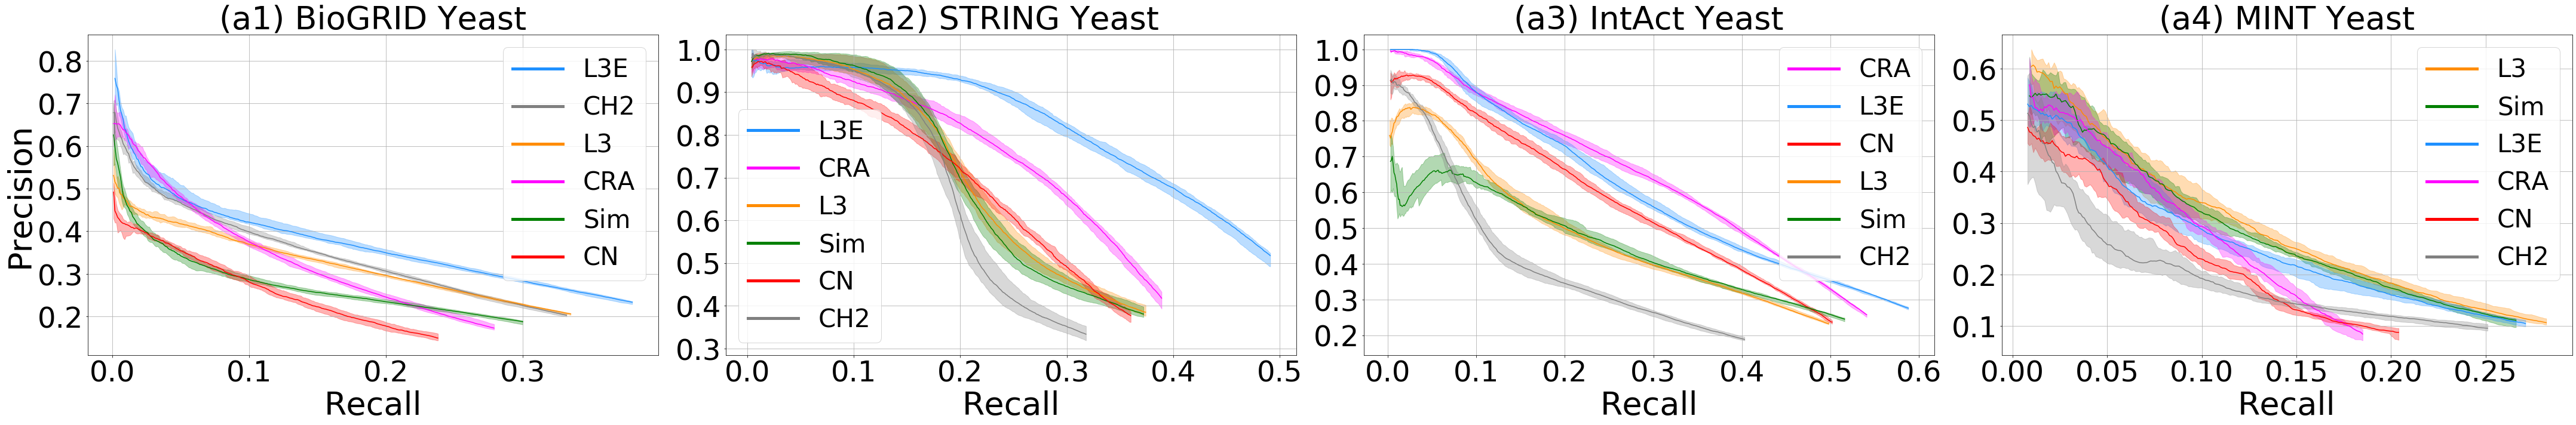

In [12]:
fNamesList = ['commonNeighbor_tenTrial_', 'L3uvJoin_tenTrial_', 'CRA_tenTrial_', 'CH2_L3_tenTrial_', 'Sim_tenTrial_', 'xyContrib_dualCN_uvJoin_tenTrial_']
tags = labels

fNamesTitle = ['(a1) BioGRID Yeast', '(a2) STRING Yeast', '(a3) IntAct Yeast', '(a4) MINT Yeast']
plt.rc('axes', titlesize=54)
plt.rc('axes', labelsize=54)
plt.rc('xtick', labelsize=48)
plt.rc('ytick', labelsize=48)
plt.rc('legend', fontsize=42) 
fig, axes = plt.subplots(1, 4, figsize=(60,10))
xIntervals, yIntervals = [0.1, 0.1, 0.1, 0.05], [0.1, 0.1, 0.1, 0.1]
datasets = ['bioGRID', 'STRING', 'IntAct_spoke', 'MINT']
for j in range(len(datasets)):
    dataset = datasets[j]
    fNames = [i+dataset for i in fNamesList]
    #tags = ['_'.join(fName.split('_')[:-2]) for fName in fNames]
    slideRange = (100, len(precRecMap[fNames[0]+"_0"]["prec"]))
    precsList = [[precRecMap[fName+"_{}".format(i)]["prec"][slideRange[0]:slideRange[1]] for i in range(10)] for fName in fNames]
    recsList = [[precRecMap[fName+"_{}".format(i)]["rec"][slideRange[0]:slideRange[1]] for i in range(10)] for fName in fNames]
    xInterval, yInterval = xIntervals[j], yIntervals[j]
    axes[j].set_xticks([i*xInterval for i in range(0, int((1+xInterval)/xInterval))])
    axes[j].set_yticks([i*yInterval for i in range(0, int((1+yInterval)/yInterval))])

    # sort the fName by curve bounding
    precCurves = {}
    for i in range(len(fNames)):
        prec, rec = precsList[i], recsList[i]
        alignedPrecs, baseRec = standardize_plots(prec, rec, 3)
        upperPrec, lowerPrec, avgPrec = get_plots_outline(alignedPrecs, max), get_plots_outline(alignedPrecs, min), get_plots_outline(alignedPrecs, median)
        precCurves[fNames[i]] = avgPrec
    
    precScores = {}
    for i in precCurves:
        precScores[i] = distance_scoring(precCurves[i], [precCurves[k] for k in precCurves if k != i])
    fNames, sVals = hr.sort_key_val(list(precScores.keys()), list(precScores.values()))
    
    # using the curve bounding to sort the legend
    for i in range(len(fNames)):      
        slideRange = (100, len(precRecMap[fNames[0]+"_0"]["prec"]))
        prec = [precRecMap[fNames[i]+"_{}".format(n)]["prec"][slideRange[0]:slideRange[1]] for n in range(10)]
        rec = [precRecMap[fNames[i]+"_{}".format(n)]["rec"][slideRange[0]:slideRange[1]] for n in range(10)]

        
        alignedPrecs, baseRec = standardize_plots(prec, rec, 3)
        upperPrec, lowerPrec, avgPrec = get_plots_outline(alignedPrecs, max), get_plots_outline(alignedPrecs, min), get_plots_outline(alignedPrecs, median)
        
        if dataset == "IntAct_spoke": tag = tags["_".join(fNames[i].split("_")[:-2])+"_"]
        else: tag = tags["_".join(fNames[i].split("_")[:-1])+"_"]
        if dataset == "IntAct_spoke": color = colors["_".join(fNames[i].split("_")[:-2])+"_"]
        else: color = colors["_".join(fNames[i].split("_")[:-1])+"_"]
        
        axes[j].fill_between(baseRec, lowerPrec, upperPrec, facecolor=color, color=color, alpha=0.3)        
        axes[j].plot(baseRec, avgPrec, color=color, label=tag)
    axes[j].set_xlabel("Recall")
    axes[j].grid()
    axes[j].set_title(fNamesTitle[j])
    leg = axes[j].legend()
    for line in leg.get_lines():
        line.set_linewidth(5.0)
        
axes[0].set_ylabel("Precision")
plt.tight_layout()
plt.savefig('./img/PRCurve_BIBE.png')
plt.show()

# Bio Significance

In [ ]:
# remember to check if PPI exists only in STRING dataset, but not STRING type dataset (STRINB_df only store those with type)

In [9]:
# top all, window 100, sliding 10, STRING
fNames = ['commonNeighbor_tenTrial_STRING', 'L3uvJoin_tenTrial_STRING', 'xyContrib_dualCN_uvJoin_tenTrial_STRING', 'uvSpec_xySpec_xyContrib_uvJoin_tenTrial_STRING', 'CRA_tenTrial_STRING', 'CH2_L3_tenTrial_STRING', 'L3Raw_tenTrial_STRING', 'Sim_tenTrial_STRING']
tags = ['_'.join(fName.split('_')[:-2]) for fName in fNames]
_, STRING_df = STRING.parse_STRING(root='../')
STRING_PPI = [tr.Helper.br_to_pathStr(list(ppi)) for ppi in np.asarray(STRING_df[['nodeA', 'nodeB']])]
STRING_PPI += [tr.Helper.br_to_pathStr(list(ppi)[::-1]) for ppi in np.asarray(STRING_df[['nodeA', 'nodeB']])]
STRING_Score = list(np.asarray(STRING_df['score']))+list(np.asarray(STRING_df['score']))
STRING_scoreMap = dict(zip(STRING_PPI, STRING_Score))

window, slidingFrame = 100, 10
ppiMMScoresList = defaultdict(list)
for fName in fNames: # 4 algorithms
    predPPI = np.asarray([tr.Helper.list_to_pathStrs(PPIs) for PPIs in predPPIs[fName]])
    for ppiArr in predPPI: # 10 trials
        ppiMMScoresList[fName].append([])
        for i in range(0, len(ppiArr)-window, slidingFrame):
            ppiCluster = ppiArr[i:i+window]
            scores = [STRING_scoreMap[ppiStr] if ppiStr in STRING_scoreMap else 0 for ppiStr in ppiCluster]
            if len(scores) > 0: ppiMMScoresList[fName][-1].append(mean(scores))
            else: ppiMMScoresList[fName][-1].append(0)

In [14]:
trimNum = {'bioGRID': int(len([*bg.parse_bioGRID(root='../')][1].index)*0.5)
        , 'STRING': int(len([*STRING.parse_STRING(root='../')][1].index)*0.5)
        , 'IntAct_spoke': int(len([*IntAct.parse_IntAct(root='../', spokeModel=True)][1].index)*0.5)
        , 'MINT': int(len([*MINT.parse_MINT(root='../')][1].index)*0.5)}


tags = ['commonNeighbor', 'L3uvJoin', 'xyContrib_dualCN_uvJoin', 'CRA', 'Sim', 'CH2_L3']
datasets = ['bioGRID', 'STRING', 'IntAct_spoke', 'MINT']
AvgGOScores, stdGOScores, GOScores_trim = {}, {}, {}
for k in range(len(datasets)):
    for tag in tags:
        flattenGO = []
        tag = '{}_tenTrial_{}'.format(tag, datasets[k])
        GOScores_trim[tag] = [j[:int(trimNum[datasets[k]]*0.1)] for j in GOScores[tag]]
        AvgGOScores[tag] = [mean(j) for j in np.transpose(np.asarray(GOScores_trim[tag]))]
        stdGOScores[tag] = np.std(AvgGOScores[tag])

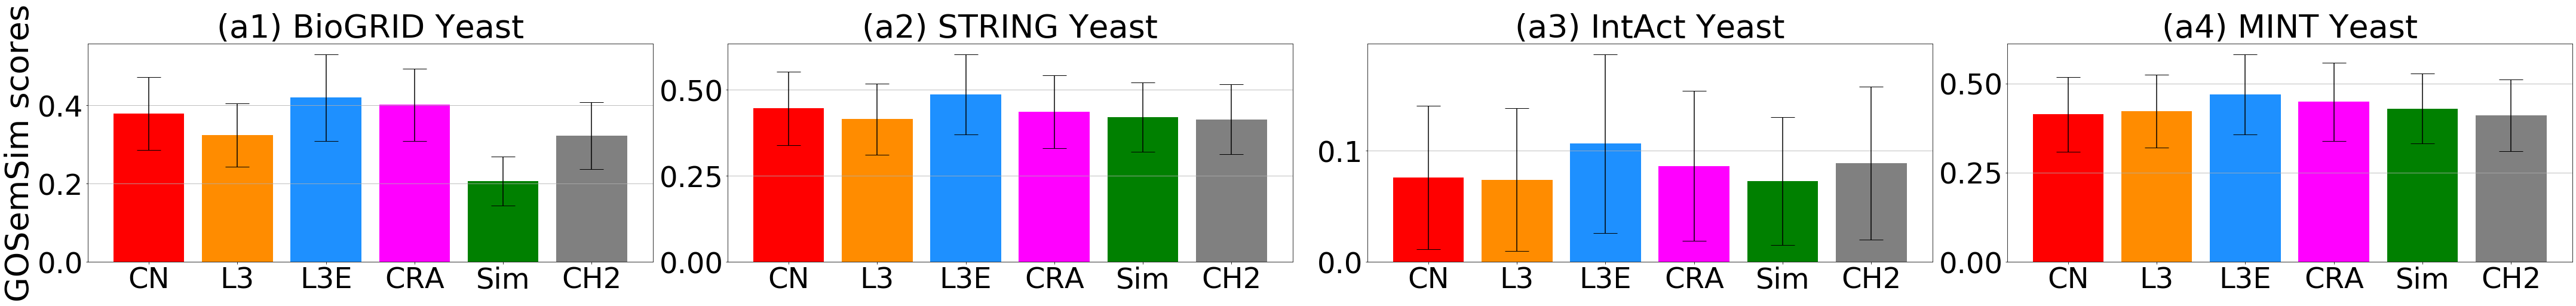

In [15]:
tags = ['commonNeighbor', 'L3uvJoin', 'xyContrib_dualCN_uvJoin', 'CRA', 'Sim', 'CH2_L3']
datasets = ['bioGRID', 'STRING', 'IntAct_spoke', 'MINT']
titles = ['(a1) BioGRID Yeast', '(a2) STRING Yeast', '(a3) IntAct Yeast', '(a4) MINT Yeast']
plt.rc('axes', titlesize=54)
plt.rc('axes', labelsize=54)
plt.rc('xtick', labelsize=48) 
plt.rc('ytick', labelsize=48) 
plt.rc('legend', fontsize=48)
fig, axes = plt.subplots(1,4,figsize=(60,7))
for k in range(len(datasets)):
    axes[k].bar([labels[tag+"_tenTrial_"] for tag in tags], [mean(AvgGOScores[tag+"_tenTrial_"+datasets[k]]) for tag in tags]
                , color=[colors[tag+"_tenTrial_"] for tag in tags], yerr=[stdGOScores[tag+"_tenTrial_"+datasets[k]] for tag in tags]
                , capsize=20)
    axes[k].grid(axis='y')
    #axes[k].set_xlabel('PPI Link Predictors')
    axes[k].set_title(titles[k])
axes[0].set_ylabel('GOSemSim scores')
plt.tight_layout()
plt.savefig('./img/GOSemSimBar_top1000_BIBE.png')
plt.show()

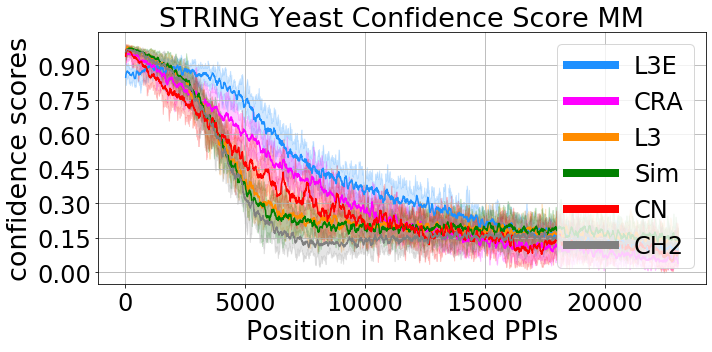

In [10]:
plt.rc('axes', titlesize=27)
plt.rc('axes', labelsize=27)
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24) 
plt.rc('legend', fontsize=24)
fig = plt.figure(figsize=(10,5))

fNames = ['commonNeighbor_tenTrial_STRING', 'L3uvJoin_tenTrial_STRING', 'CRA_tenTrial_STRING', 'Sim_tenTrial_STRING', 'CH2_L3_tenTrial_STRING', 'xyContrib_dualCN_uvJoin_tenTrial_STRING']
xInterval, yInterval = 5000, 0.15
xList = [(i+1)*10 for i in range(len(ppiMMScoresList[fNames[0]][0]))]
xTicks, yTicks = [i*xInterval for i in range(0, int(len(xList)+xInterval/xInterval))], [i*yInterval for i in range(0, int((1+yInterval)/yInterval))]
plt.xticks(xTicks)
plt.yticks(yTicks)

# sort the fName by curve bounding
precCurves = {}
for i in range(len(fNames)):
    avgScore = get_plots_outline(ppiMMScoresList[fNames[i]], mean)
    precCurves[fNames[i]] = avgScore

precScores = {}
for i in precCurves:
    precScores[i] = distance_scoring(precCurves[i], [precCurves[k] for k in precCurves if k != i])
fNames, sVals = hr.sort_key_val(list(precScores.keys()), list(precScores.values()))


for i in range(len(fNames)):
    upperScore, lowerScore, avgScore = get_plots_outline(ppiMMScoresList[fNames[i]], max), get_plots_outline(ppiMMScoresList[fNames[i]], min), get_plots_outline(ppiMMScoresList[fNames[i]], mean)
    fNames[i] = "_".join(fNames[i].split("_")[:-1])+"_"
    plt.fill_between(xList, lowerScore, upperScore, facecolor=colors[fNames[i]], color=colors[fNames[i]], alpha=0.2)
    plt.plot(xList, avgScore, color=colors[fNames[i]], label=labels[fNames[i]])
ax = plt.gca()
ax.set_xlabel('Position in Ranked PPIs')
ax.set_ylabel('confidence scores')
ax.set_title('STRING Yeast Confidence Score MM')
ax.grid()
leg = plt.legend(loc="upper right")
for line in leg.get_lines():
    line.set_linewidth(8.0)
plt.tight_layout()
plt.savefig('./img/confScore_BIBE.png')
plt.show()

# Essential Gene Growth Rate

In [12]:
tags = ['commonNeighbor_tenTrial_', 'L3uvJoin_tenTrial_', 'xyContrib_dualCN_uvJoin_tenTrial_', 'CRA_tenTrial_', 'CH2_L3_tenTrial_', 'Sim_tenTrial_']
fNamesList = [tag+dataset for tag in tags for dataset in ['STRING', 'bioGRID', 'MINT', 'IntAct_spoke']]
hitNum = {}
for fName in fNamesList:
    currPredPPI = predPPIs[fName]
    hitList = []
    for i in range(0, 10):
        hitList.append([])
        nodeList = set()
        for k in range(0, len(currPredPPI[i])):
            nodeList.update(currPredPPI[i][k])
            hitList[-1].append(len(nodeList&essGenes))
    hitNum[fName] = hitList.copy()
with open('./resultData/hitNumDict.json', 'w') as f:
    f.write(json.dumps(hitNum))

In [13]:
tags = ['commonNeighbor_tenTrial_', 'L3uvJoin_tenTrial_', 'xyContrib_dualCN_uvJoin_tenTrial_', 'CRA_tenTrial_', 'CH2_L3_tenTrial_', 'Sim_tenTrial_']
fNamesList = [tag+dataset for tag in tags for dataset in ['STRING', 'bioGRID', 'IntAct_spoke', 'MINT']]
essDegDict = {}
for fName in fNamesList:
    currPredPPI = predPPIs[fName]
    essDegs = []
    if 'bioGRID' in fName: samplePPIr = bg_samplePPIr.copy()
    elif 'STRING' in fName: samplePPIr = STRING_samplePPIr.copy()
    elif 'MINT' in fName: samplePPIr = MINT_samplePPIr.copy()
    elif 'IntAct' in fName and 'spoke' in fName: samplePPIr = IntAct_spoke_samplePPIr.copy()
    for i in range(0, 10):
        essDegs.append([])
        essNodes = set()
        nodeList = set()
        for k in range(0, len(currPredPPI[i])):
            nodeList.update(currPredPPI[i][k])
            newEss = (nodeList&essGenes)-essNodes
            essNodes.update(newEss)
            essDegs[-1].append([len(samplePPIr[i][node]) for node in newEss])
    essDegDict[fName] = essDegs.copy()
with open('./resultData/essDegDict.json', 'w') as f:
    f.write(json.dumps(essDegDict))

In [11]:
hitNum = {}
with open('./resultData/hitNumDict.json', 'r') as f:
    hitNum = json.loads(f.read())
essDegDict = {}
with open('./resultData/essDegDict.json', 'r') as f:
    essDegDict = json.loads(f.read())

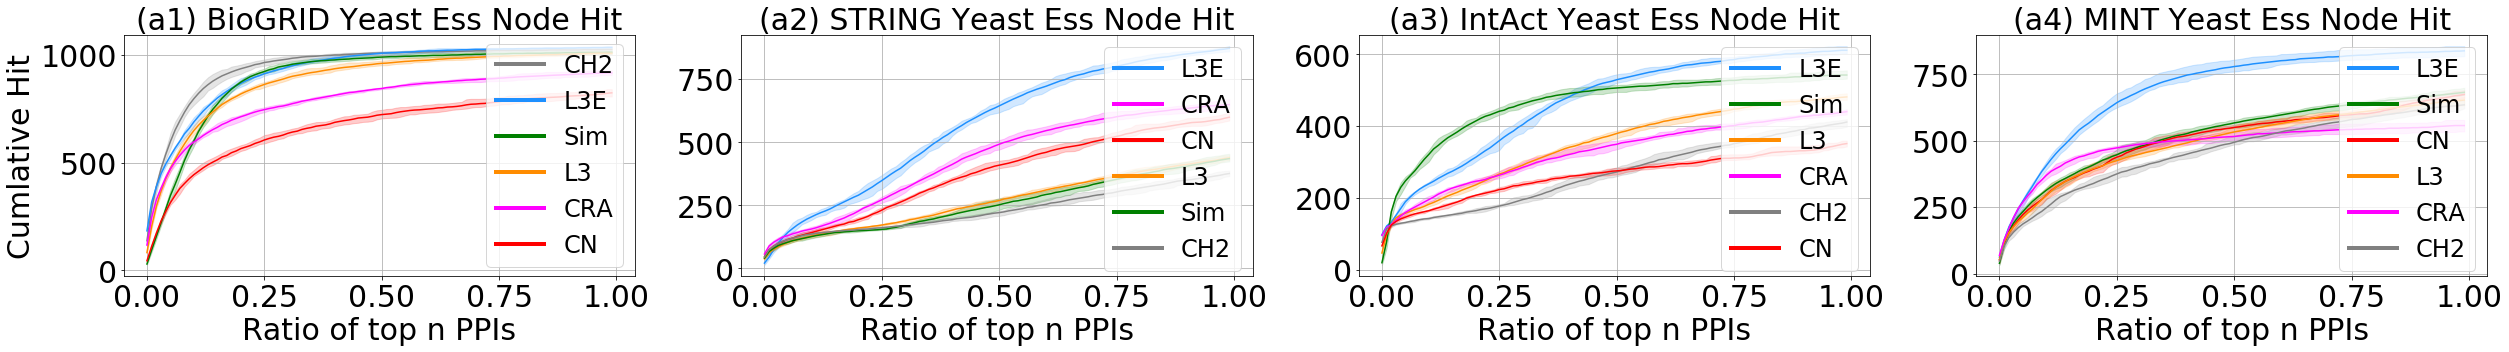

In [17]:
## use essGenes list
fNamesList = ['commonNeighbor_tenTrial_', 'L3uvJoin_tenTrial_', 'xyContrib_dualCN_uvJoin_tenTrial_', 'CRA_tenTrial_', 'CH2_L3_tenTrial_', 'Sim_tenTrial_']
color = ['red', 'darkorange', 'fuchsia', 'green', 'dodgerblue', 'darkorchid', 'grey']
fNamesTitle = ['(a1) BioGRID Yeast Ess Node Hit', '(a2) STRING Yeast Ess Node Hit', '(a3) IntAct Yeast Ess Node Hit', '(a4) MINT Yeast Ess Node Hit']

plt.rc('axes', titlesize=30)
plt.rc('axes', labelsize=30)
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30)
plt.rc('legend', fontsize=24)
fig, axes = plt.subplots(1, 4, figsize=(35,5))
datasets = ['bioGRID', 'STRING', 'IntAct_spoke', 'MINT']
for j in range(len(datasets)):
    fNames = [i+datasets[j] for i in fNamesList]

    # sort the fName by curve bounding
    precCurves = {}
    for i in range(len(fNames)):
        hitList = hitNum[fNames[i]]
        xList = [[(k+1)/len(l) for k in range(0, len(l))] for l in hitList]
        alignedHit, baseX = standardize_plots(hitList, xList, 2)
        avgHit = get_plots_outline(alignedHit, mean)
        precCurves[fNames[i]] = avgHit

    precScores = {}
    for i in precCurves:
        precScores[i] = distance_scoring(precCurves[i], [precCurves[k] for k in precCurves if k != i])
    fNames, sVals = hr.sort_key_val(list(precScores.keys()), list(precScores.values()))
    
    if datasets[j] == 'IntAct_spoke':
        label = [labels["_".join(i.split("_")[:-2])+"_"] for i in fNames]
        color = [colors["_".join(i.split("_")[:-2])+"_"] for i in fNames]
    else:
        label = [labels["_".join(i.split("_")[:-1])+"_"] for i in fNames]
        color = [colors["_".join(i.split("_")[:-1])+"_"] for i in fNames]
    
    for i in range(len(fNames)):
        hitList = hitNum[fNames[i]]
        xList = [[(k+1)/len(l) for k in range(0, len(l))] for l in hitList]
        alignedHit, baseX = standardize_plots(hitList, xList, 2)
        upperHit, lowerHit, avgHit = get_plots_outline(alignedHit, max), get_plots_outline(alignedHit, min), get_plots_outline(alignedHit, mean)
        axes[j].fill_between(baseX, lowerHit, upperHit, facecolor=color[i], color=color[i], alpha=0.2)
        axes[j].plot(baseX, avgHit, color=color[i], label=label[i])
        axes[j].set_xticks([i/100 for i in range(0,110,25)])
    axes[j].set_xlabel("Ratio of top n PPIs")
    axes[j].grid()
    axes[j].set_title(fNamesTitle[j])
    if j == 0: leg = axes[j].legend(loc='right')
    else: leg = axes[j].legend()
    for line in leg.get_lines():
        line.set_linewidth(4.0)
#axes[3].legend()
axes[0].set_ylabel("Cumlative Hit")
plt.tight_layout()
plt.savefig('./img/essGeneFreq.png')
plt.show()

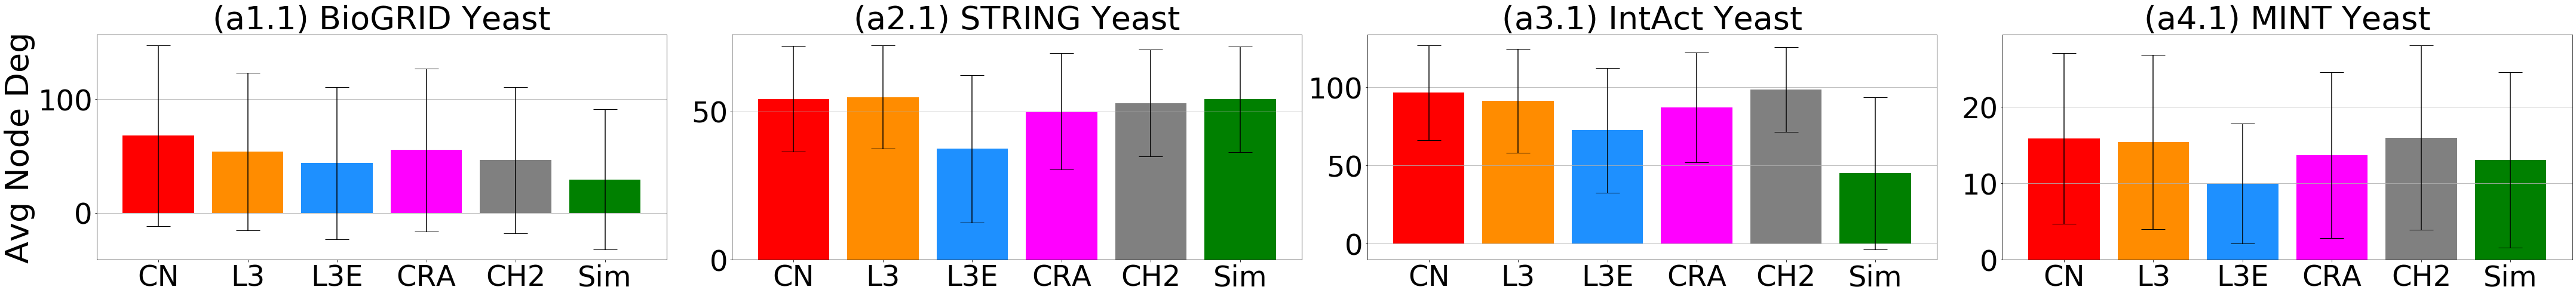

In [13]:
color = ['red', 'darkorange', 'fuchsia', 'green', 'dodgerblue', 'darkorchid', 'grey']

fNamesList = ['commonNeighbor_tenTrial_', 'L3uvJoin_tenTrial_', 'xyContrib_dualCN_uvJoin_tenTrial_', 'CRA_tenTrial_', 'CH2_L3_tenTrial_', 'Sim_tenTrial_']
datasets = ['bioGRID', 'STRING', 'IntAct_spoke', 'MINT']
titles = ['(a1.1) BioGRID Yeast', '(a2.1) STRING Yeast', '(a3.1) IntAct Yeast', '(a4.1) MINT Yeast']
plt.rc('axes', titlesize=54)
plt.rc('axes', labelsize=54)
plt.rc('xtick', labelsize=48) 
plt.rc('ytick', labelsize=48) 
plt.rc('legend', fontsize=48)
fig, axes = plt.subplots(1,4,figsize=(60,7))
topNo = 1000
for k in range(len(datasets)):
    dataset = datasets[k]
    fNames = [i+dataset for i in fNamesList]
    meanEssDeg, stdDeg = [], []
    for i in range(len(fNames)):
        tmp = [a for t in essDegDict[fNames[i]] for a in t[:int(len(t)*0.1)] if len(a) > 0]
        topEssDeg = []
        for t in tmp: topEssDeg += t
        stdDeg.append(np.std(topEssDeg))
        meanEssDeg.append(mean(topEssDeg))
        
    axes[k].bar([labels[tag] for tag in fNamesList], meanEssDeg
                , color=[colors[tag] for tag in fNamesList], yerr=stdDeg
                , capsize=20)
    axes[k].grid(axis='y')
    #axes[k].set_xlabel('PPI Link Predictors')
    axes[k].set_title(titles[k])
axes[0].set_ylabel('Avg Node Deg')
plt.tight_layout()
plt.savefig('./img/EssGeneBar_top1000_BIBE.png')
plt.show()